# Test attention

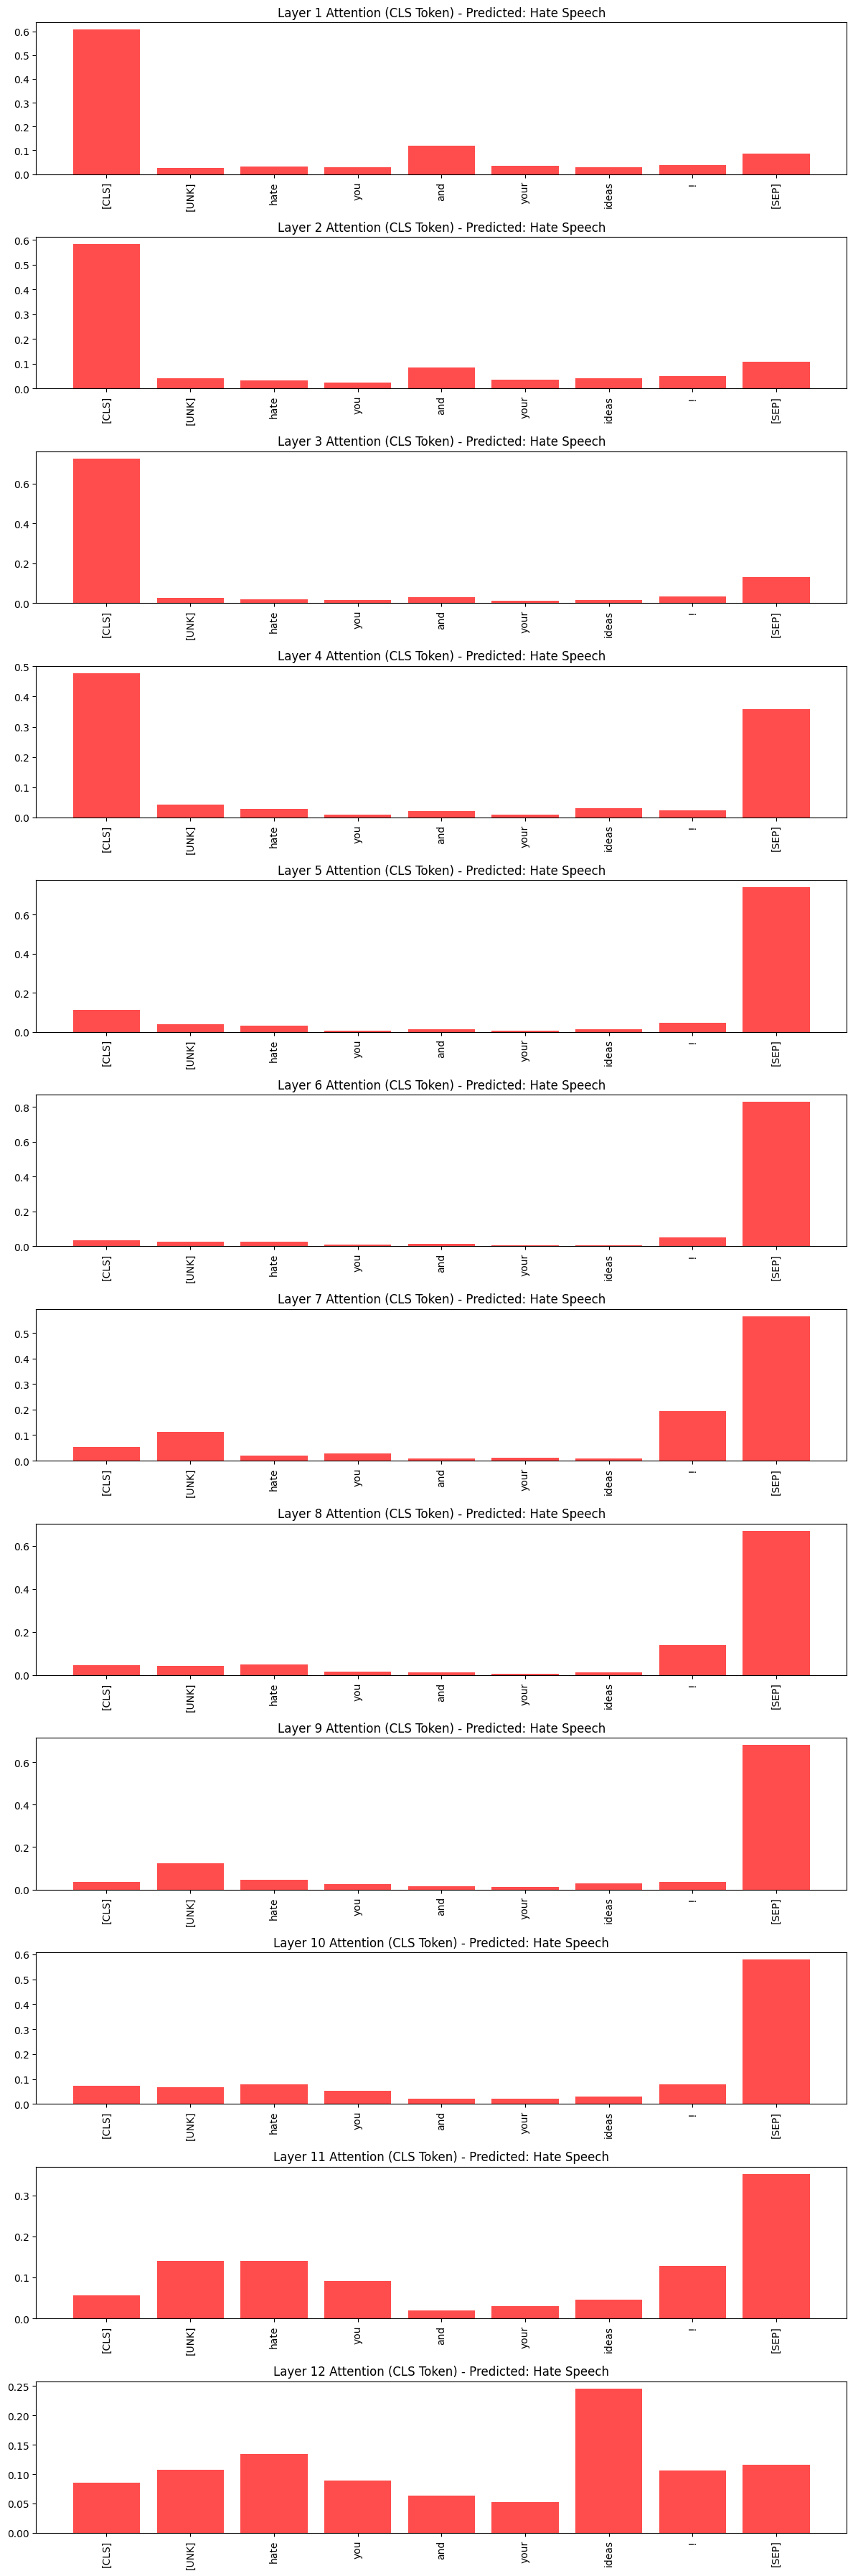

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np

# Load a pre-trained hate speech detection model
model_name = "hate-speech-CNERG/bert-base-uncased-hatexplain"  # Example model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
model.eval()

# Input sentence
sentence = "I hate you and your ideas!"

# Tokenize input and get attention outputs
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
with torch.no_grad():
    outputs = model(**inputs)

# Get logits, attentions, and predicted label
logits = outputs.logits
predicted_label = torch.argmax(logits, dim=-1).item()
all_attentions = outputs.attentions  # Attention scores from all layers

# Token-level interpretation for each layer
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
layer_cls_attentions = []

for layer_idx, attentions in enumerate(all_attentions):
    # Average attention over heads
    layer_average_attention = attentions.mean(dim=1)  # Shape: (batch_size, seq_len, seq_len)
    # Extract attention for the CLS token
    cls_attention = layer_average_attention[:, 0, :]  # Attention for CLS token
    layer_cls_attentions.append(cls_attention.squeeze().numpy())

# Visualize attention heatmap for each layer
plt.figure(figsize=(12, len(layer_cls_attentions) * 3))
for i, cls_attention in enumerate(layer_cls_attentions):
    plt.subplot(len(layer_cls_attentions), 1, i + 1)
    plt.bar(range(len(tokens)), cls_attention, alpha=0.7, color="red" if predicted_label == 1 else "blue")
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title(f"Layer {i + 1} Attention (CLS Token) - Predicted: {'Hate Speech' if predicted_label == 1 else 'Non-Hate Speech'}")

plt.tight_layout()
plt.show()
